# Project PA 228 - Image Classification
### - Kuldeep Singh, 541673

The task is to classify several cropped satellite images of the Amazon using multiple pre-defined labels such as atmospheric conditions and classes of land cover. I have downloaded data from https://www.kaggle.com/datasets/nikitarom/planets-dataset

Final Analysis of Results is appended in last cell.

In [2]:
#uncomment code in next cell for downloading dataset

In [3]:
# import zipfile
# !git clone https://github.com/KSRAJAWAT111/planet-dataset.git
# with zipfile.ZipFile('planet-dataset/planet_.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

In [4]:
import torch
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose
from tqdm import tqdm
from torchvision import transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from torchsummary import summary
import torch.nn.functional as F

#### Loading labels CSV

In [6]:
classes = pd.read_csv(r"planet/train_classes.csv")

In [7]:
classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
classes.shape

(40479, 2)

We have multiple lables for 40479 training images.

In [9]:
#Finding how many unique tags are there
labels = set()
for i in range(len(classes)):
    tags = classes['tags'][i].split(' ')
    labels.update(tags)
labels = sorted(labels)

In [10]:
print(len(labels))
labels

17


['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

#### Visualising few images from dataset

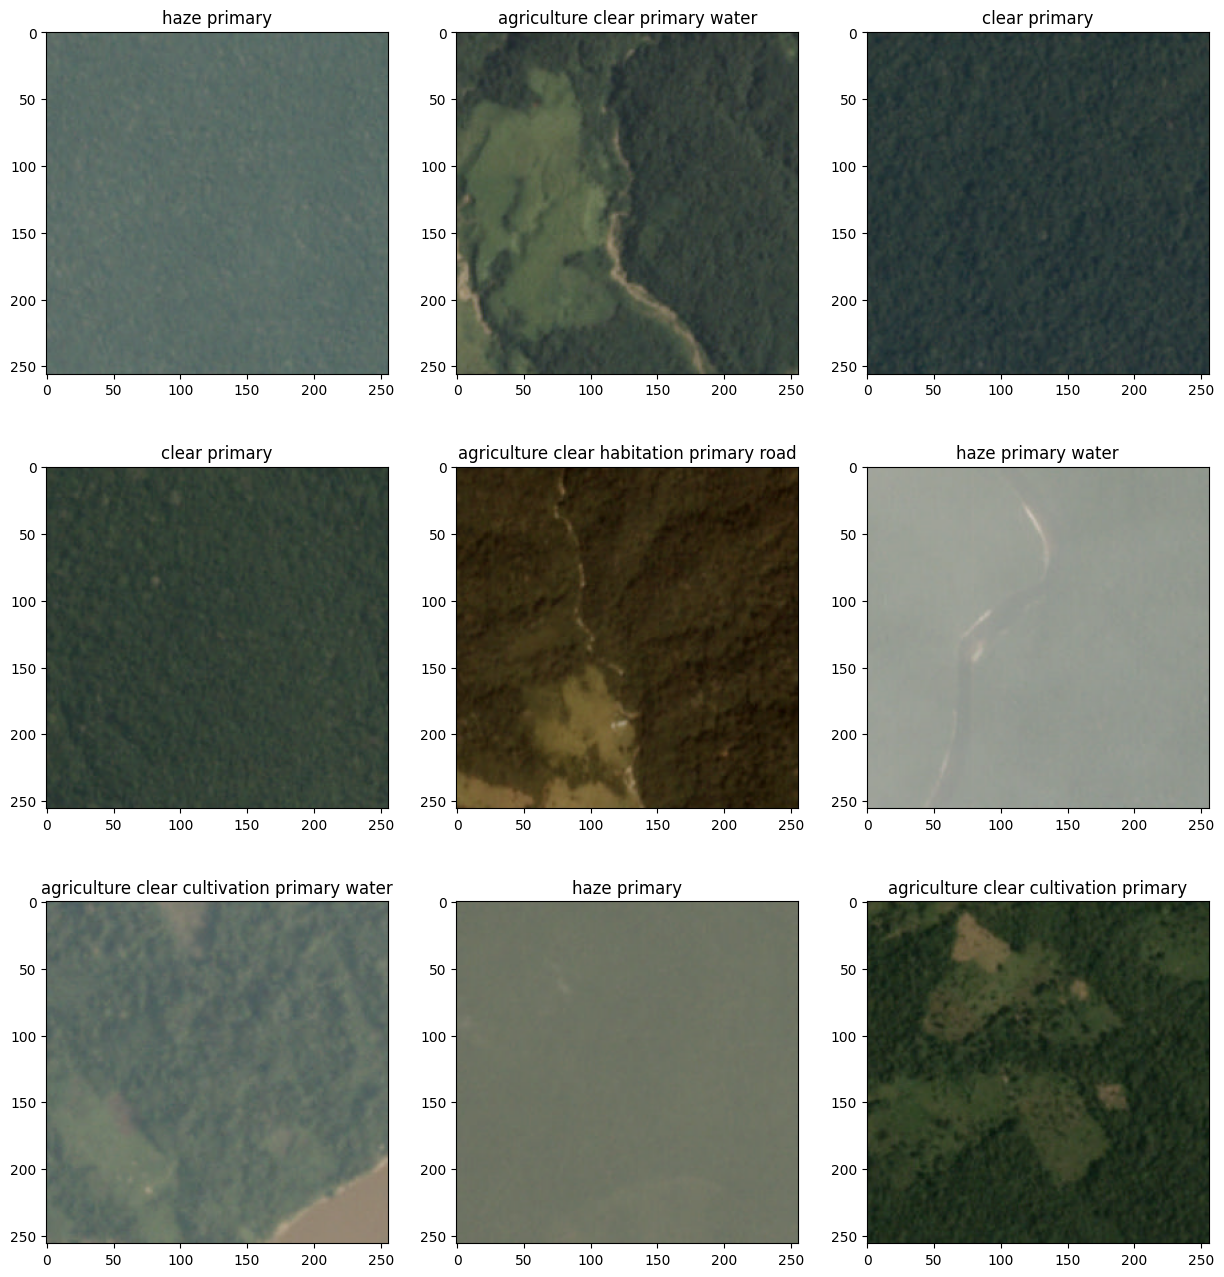

In [11]:
import matplotlib.image as mpimg

# Create a figure and axes object
fig, axs = plt.subplots(3, 3, figsize=(15, 16))

for i in range(9):
    filename = "planet/train-jpg/"+ 'train_' + str(i) + '.jpg'
    img = mpimg.imread(filename)
    # Get the row and column indices of the current image
    row, col = divmod(i, 3)
    label = classes.loc[classes['image_name'] == 'train_' + str(i), 'tags'].iloc[0]

    # Plot the image in the corresponding subplot
    axs[row, col].imshow(img)
    axs[row, col].set_title(label)
    

#### Converting labes to one hot vector

In [12]:
classes_one_hot = pd.DataFrame()
classes_one_hot['image_name'] = classes['image_name']
for label in labels:
    classes_one_hot[label] = classes['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

In [13]:
classes_one_hot.head()

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


#### Visualising label distribution

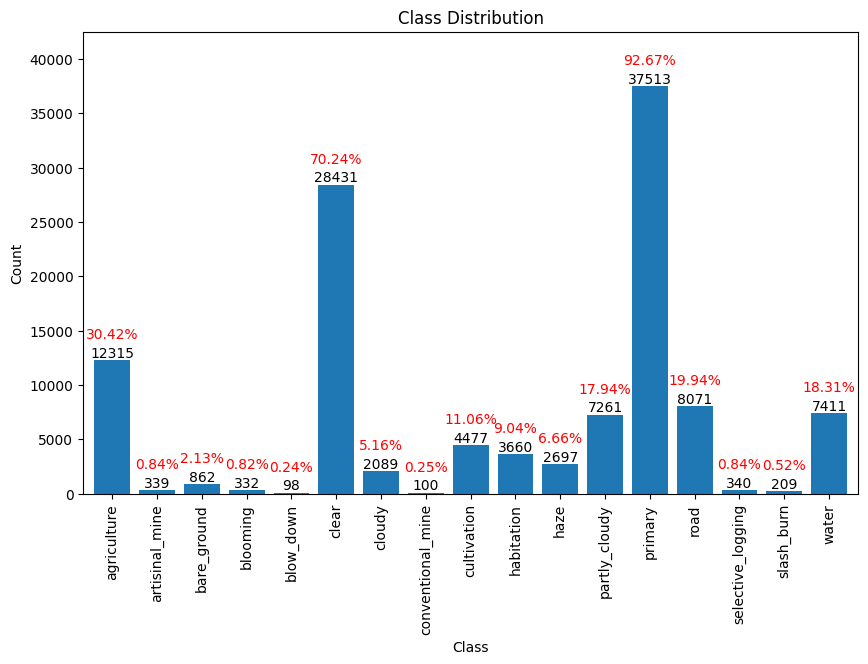

In [14]:
sums = classes_one_hot.select_dtypes(np.number).sum().rename('count')
total_count = len(classes_one_hot)
percentages = (sums / total_count) * 100

# Create bar plot with annotations
fig, ax = plt.subplots(figsize=(10, 6))
sums.plot.bar(ax=ax, width=0.8)
for i, val in enumerate(sums.values):
    ax.annotate(int(val), (i, val), ha='center', va='bottom', fontsize=10)
    ax.annotate(f"{percentages[i]:.2f}%", (i, val + 2000), ha='center', fontsize=10, color='red')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.ylim(0, max(sums.values) + 5000)
plt.show()


#### looking at co occurance of tags

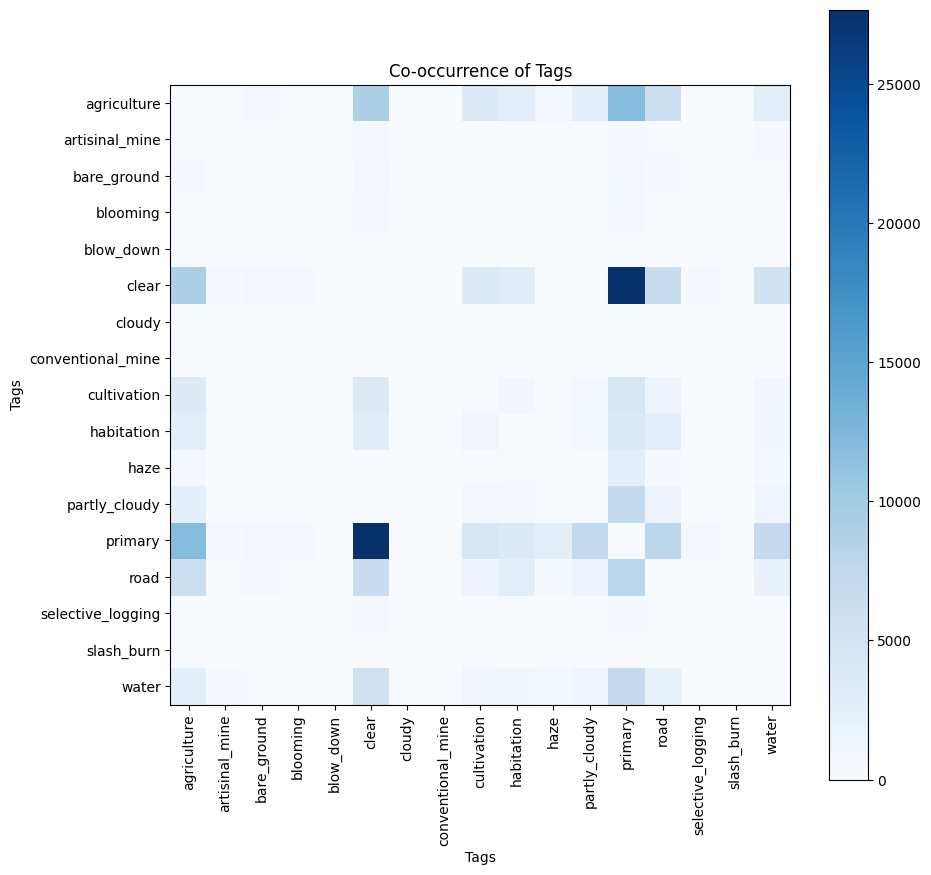

In [15]:
from itertools import combinations
tag_to_idx = {tag: i for i, tag in enumerate(labels)}

# Create a co-occurrence matrix
cooc_mat = np.zeros((len(labels), len(labels)), dtype=int)
for row in classes['tags']:
    tag_list = row.split()
    for i, j in combinations(tag_list, 2):
        cooc_mat[tag_to_idx[i], tag_to_idx[j]] += 1
        cooc_mat[tag_to_idx[j], tag_to_idx[i]] += 1

# Plot the co-occurrence matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cooc_mat, cmap='Blues')

# Set tick labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.title('Co-occurrence of Tags')
plt.xlabel('Tags')
plt.ylabel('Tags')
plt.show()


#### Loading images and labels and converting 40000 to Numpy array

In [16]:
#loading images
from tensorflow.keras.utils import load_img,img_to_array
img_height = 128
img_width = 128
x = []
for i in tqdm(range(classes.shape[0])):
    filename = "planet/train-jpg/"+ 'train_' + str(i) + '.jpg'
    img = load_img(filename,target_size=(img_width,img_height))
    img = img_to_array(img)
    img = img/255.0
    x.append(img)

2023-04-25 11:55:43.605585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 11:55:44.364590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|███████████████████████████████████████████████████████████████████████████| 40479/40479 [00:33<00:00, 1221.38it/s]


In [17]:
X = np.array(x[0:40000])

In [18]:
#Loading labels
y = classes_one_hot.iloc[0:40000,1:].to_numpy()

In [19]:
X.shape,  y.shape

((40000, 128, 128, 3), (40000, 17))

#### Finding mean and Std of our dataset

In [20]:
# mean = np.mean(X, axis=(0,1,2))
# std = np.std(X, axis=(0,1,2))
# print("mean:  ", mean)
# print("std:  ", std)

# mean:   [0.0256 0.0256 0.0256]
# std:   [0.16       0.16       0.14595467]

#### Configuration file for project

In [22]:
config = {
    'batch_size': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20
}

#### Defining Py Torch dataset class

In [50]:
class PlanetDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, augmentation=False):
        self.x = x
        self.y = y
        self.augmentation = augmentation


        self.transform = T.Compose([
            T.ToTensor(),
            T.Resize((128, 128),antialias=True),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

        self.augment = A.Compose(
            [A.HorizontalFlip(p=0.5),
             A.VerticalFlip(p=0.5),
             A.ShiftScaleRotate(shift_limit=4, rotate_limit=45),
            ])
        

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        img = self.x[index]
        if self.augmentation:
            img = self.augment(image=img)['image']
            y = self.y[index].astype('float')
        return self.transform(img), self.y[index]


#### Test train split and Training and Test Data loaders
Set agumentation = True or False as desired

In [24]:
def create_data_loaders(X=X, y=y, batch_size=config['batch_size'], shuffle_train=True, shuffle_test=False, augmentation=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_ds = PlanetDataset(X_train, y_train, augmentation=augmentation)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_train)
    valid_ds = PlanetDataset(X_test, y_test, augmentation=augmentation)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=shuffle_test)
    return train_dl, valid_dl

In [25]:
t,v = create_data_loaders(augmentation=False)
train_iter = iter(t)

# Get one first two samples
sample1 = next(train_iter)
sample1[0].shape # (batch_size, channel,height, width)

torch.Size([128, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


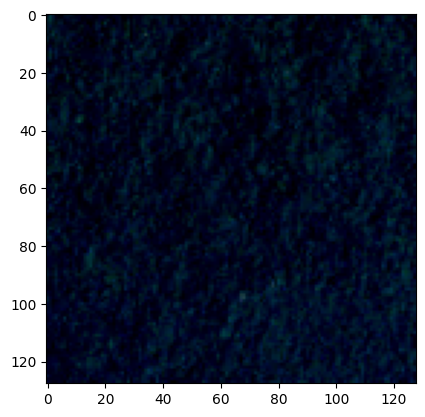

In [26]:
#Visualising our data after transformation
image, label = sample1[0][0], sample1[1][0]
# Convert the image to a numpy array
image = np.transpose(image.numpy(), (1, 2, 0))

# Plot the image
plt.imshow(image)
plt.show()


In [27]:
image.min(), image.max()

(-0.4739276, 0.32191727)

#### Defining Vanilla CNN
Set use_dropout = True if dropout required

In [52]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=17, use_dropout=True):
        super(MyCNN, self).__init__()
        
        dropout_prob = 0.5 if use_dropout else 0.0
        print("Dropout:",use_dropout)
        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=dropout_prob),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


#### Definig VGG16 for Multilabel Classification 
Set use_dropout = True or False as desired. The model which is commented does not freeze the VGG CLassifier and has all 134,330,193 parameters trainable. The model below has freezed classifier and has only 2,106,385 trainable parameters out of 134,330,193.

In [53]:
class VGG16MultiLabel(nn.Module):   #UnFrozen version
    def __init__(self, num_classes=17, use_dropout=True):
        super(VGG16MultiLabel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        print("Dropout: ",use_dropout)    
        dropout_prob = 0.5 if use_dropout else 0.0

        self.vgg16.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
            nn.Linear(in_features=4096, out_features=num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        x = self.vgg16(x)
        return x



# class VGG16MultiLabel(nn.Module):     #Frozen version
#     def __init__(self, num_classes=17, use_dropout=True):
#         super(VGG16MultiLabel, self).__init__()
#         self.vgg16 = models.vgg16(pretrained=True)
        
#         # Freeze all layers in the VGG16 model
#         for param in self.vgg16.parameters():
#             param.requires_grad = False
        
#         # Replace the last layer to output 17 classes with sigmoid activation
#         print("Dropout:",use_dropout)
#         dropout_prob = 0.5 if use_dropout else 0.0
#         self.vgg16.classifier[-1] = nn.Sequential(
#             nn.Linear(4096, 512),
#             nn.ReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(512, num_classes),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         x = self.vgg16(x)
#         return x

#### Defining Fit Function
Set augmentation=True/False as required, set transfet = True, if want to use VGG16 and False for Vanilla CNN, set use_dropout =True if want to use dropout layer, All other parameters need to be changed in configuration file above

In [29]:
def fit(augmentation=False, transfer=True,use_dropout=True, opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'], device=dev):
    criterion = nn.BCELoss()
    
    train_loader, valid_loader = create_data_loaders(augmentation=augmentation)
    
    if transfer:
        model = VGG16MultiLabel(use_dropout=use_dropout)
    else:
        model = MyCNN(use_dropout=use_dropout)
    model = model.to(dev)
    
    summary(model, (3, 128, 128))
    
    if opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        print("Optimizer: SDG")
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print("Optimizer: Adam")
        
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        # Train phase
        model.train()
        train_loss, train_acc = 0, 0
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Train') as pbar:
            for data, target in pbar:
                data, target = data.to(device), target.float().to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * data.size(0)
                # train_acc += accuracy(output, target) * data.size(0)
                train_acc += weighted_fbeta_score(output, target) * data.size(0)
                
              
        train_loss /= len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad(), tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation') as pbar:
            for data, target in pbar:
                data, target = data.to(device), target.float().to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item() * data.size(0)
                # val_acc += accuracy(output, target) * data.size(0)
                val_acc += weighted_fbeta_score(output, target) * data.size(0)
                
            val_loss /= len(valid_loader.dataset)
            val_acc /= len(valid_loader.dataset)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}')
    
    return model, history


#### Defining accuracy and weighted Fbeta function
Weighted Fbeta has been used as it is a multiclass problem

In [30]:
def accuracy(output, target):
    with torch.no_grad():
        pred = (output > 0.5).float()
        acc = (pred == target).float().sum() / target.size(0) / target.size(1)
    return acc.item()

from sklearn.metrics import fbeta_score

def weighted_fbeta_score(output, target, beta=2):
    with torch.no_grad():
        # pred = torch.round(output)
        pred = (output > 0.5).float()
        pred = pred.cpu().numpy()
        target = target.cpu().numpy()
        fbeta = fbeta_score(target, pred, beta=beta, average='weighted', zero_division=1)
        # if np.sum(target) + np.sum(pred) == 0:
            # fbeta = 1.0
        return fbeta

#### Function for plotting loss and accuracy curves

In [31]:
def plot_learning_curve(history, epoch=config['epochs']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation accuracy values
    epoch_range = range(1, epoch+1)
    ax1.plot(epoch_range, history['train_acc'])
#     ax1.plot(epoch_range, history.history['accuracy'])
    ax1.plot(epoch_range, history['val_acc'])
#     ax1.plot(epoch_range, history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    # Plot training and validation loss
    ax2.plot(epoch_range, history['train_loss'])
    ax2.plot(epoch_range, history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')

    plt.show()

#### Functions for predicting labels for new images
Call visual_predict(model,start_index,end_index) for visual output

In [51]:
def predict_labels(img_path, model):
    preprocess = T.Compose([
        T.Resize((128, 128)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    image_array = np.array(img)
    image_array = image_array/255.0
    image_tensor = torch.from_numpy(image_array)
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0).to(dev)  # add batch dimension

    # Switch to evaluation mode and disable gradient calculation
    model.eval()
    with torch.no_grad():
        # Get the model's prediction
        prediction = model(img_tensor)

#     Get labels for predictions greater than threshold
    labels = classes_one_hot.columns[1:]
    indices = torch.where(prediction > 0.5)[1]
    selected_labels = [labels[i.item()] for i in indices]

    return selected_labels

def visual_predict(model, start_index, end_index):
    results = []
    for i in range(start_index, end_index+1):
        img_path = "planet/train-jpg/"+ 'train_' + str(i) + '.jpg'
        img_name = 'train_' + str(i)
        labels = predict_labels(img_path, model)
        results.append({"image_name": img_name, "tags": labels})
    pred_label = pd.DataFrame(results)
    print("Predicted label Dataframe:\n", pred_label)
    print("\n\noriginal label Dataframe:\n", classes[start_index:end_index+1])

## Approach 1

config = {
    'batch_size': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= False

Model = MyCNN(use_dropout=Flase)

In [58]:
model, history = fit(augmentation=False,transfer=False,use_dropout=False, opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

Dropout: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         Dropout2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
        Dropout2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14    

Epoch 1/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.87it/s]


Epoch 1/20, train loss: 0.2137, val loss: 0.1757, train acc: 0.6586, val acc: 0.6911


Epoch 2/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.61it/s]


Epoch 2/20, train loss: 0.1757, val loss: 0.1584, train acc: 0.7164, val acc: 0.7264


Epoch 3/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.69it/s]


Epoch 3/20, train loss: 0.1617, val loss: 0.1519, train acc: 0.7408, val acc: 0.7603


Epoch 4/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 20.28it/s]


Epoch 4/20, train loss: 0.1532, val loss: 0.1475, train acc: 0.7551, val acc: 0.7632


Epoch 5/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.75it/s]


Epoch 5/20, train loss: 0.1484, val loss: 0.1393, train acc: 0.7646, val acc: 0.7774


Epoch 6/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 16.71it/s]


Epoch 6/20, train loss: 0.1443, val loss: 0.1416, train acc: 0.7704, val acc: 0.7714


Epoch 7/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.08it/s]


Epoch 7/20, train loss: 0.1405, val loss: 0.1323, train acc: 0.7765, val acc: 0.7757


Epoch 8/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.89it/s]


Epoch 8/20, train loss: 0.1371, val loss: 0.1344, train acc: 0.7821, val acc: 0.7711


Epoch 9/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.95it/s]


Epoch 9/20, train loss: 0.1349, val loss: 0.1312, train acc: 0.7852, val acc: 0.8011


Epoch 10/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.65it/s]


Epoch 10/20, train loss: 0.1328, val loss: 0.1285, train acc: 0.7889, val acc: 0.7915


Epoch 11/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.34it/s]


Epoch 11/20, train loss: 0.1309, val loss: 0.1277, train acc: 0.7914, val acc: 0.7874


Epoch 12/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.69it/s]


Epoch 12/20, train loss: 0.1294, val loss: 0.1255, train acc: 0.7941, val acc: 0.8023


Epoch 13/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.49it/s]


Epoch 13/20, train loss: 0.1271, val loss: 0.1240, train acc: 0.7979, val acc: 0.8004


Epoch 14/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.64it/s]


Epoch 14/20, train loss: 0.1255, val loss: 0.1220, train acc: 0.8026, val acc: 0.8100


Epoch 15/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 20.59it/s]


Epoch 15/20, train loss: 0.1245, val loss: 0.1301, train acc: 0.8028, val acc: 0.7806


Epoch 16/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.76it/s]


Epoch 16/20, train loss: 0.1233, val loss: 0.1223, train acc: 0.8050, val acc: 0.8080


Epoch 17/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.78it/s]


Epoch 17/20, train loss: 0.1217, val loss: 0.1190, train acc: 0.8079, val acc: 0.8137


Epoch 18/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.85it/s]


Epoch 18/20, train loss: 0.1208, val loss: 0.1171, train acc: 0.8102, val acc: 0.8025


Epoch 19/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.72it/s]


Epoch 19/20, train loss: 0.1194, val loss: 0.1202, train acc: 0.8131, val acc: 0.8063


Epoch 20/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.49it/s]

Epoch 20/20, train loss: 0.1180, val loss: 0.1167, train acc: 0.8151, val acc: 0.8091


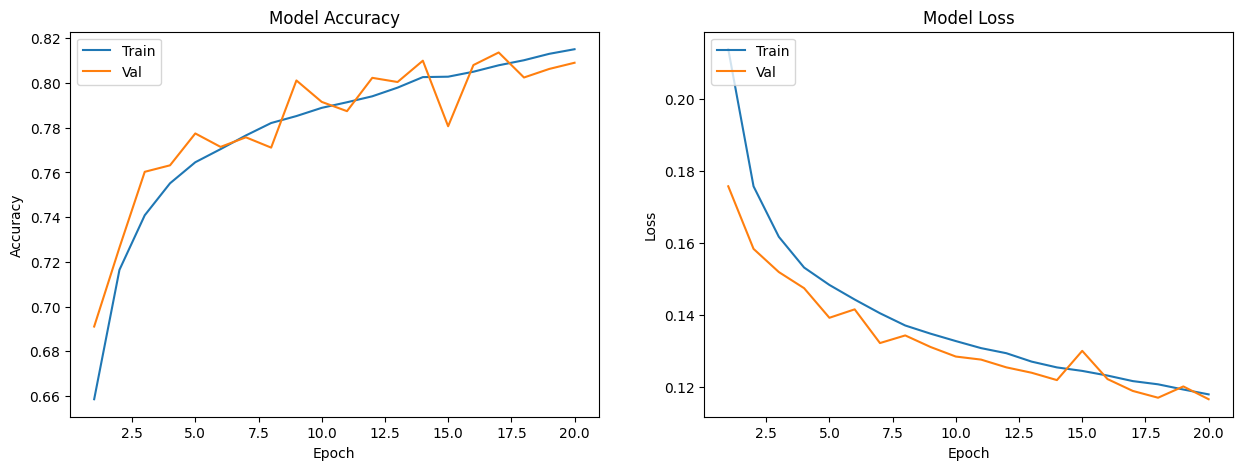

In [60]:
plot_learning_curve(history)

#### Visually looking at predicted labels and true for some new images

In [61]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                          tags
0   train_40458                 [agriculture, clear, primary]
1   train_40459                              [clear, primary]
2   train_40460                              [clear, primary]
3   train_40461                                      [cloudy]
4   train_40462                              [clear, primary]
5   train_40463                              [primary, water]
6   train_40464  [agriculture, partly_cloudy, primary, water]
7   train_40465                              [clear, primary]
8   train_40466                              [clear, primary]
9   train_40467          [agriculture, clear, primary, water]
10  train_40468          [agriculture, clear, primary, water]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460    

## Approach 2 Setting dropout = True

config = {
    'batch_size': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= False

Model = MyCNN(use_dropout=True)

In [62]:
model, history = fit(augmentation=False,transfer=False,use_dropout=True, opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

Dropout: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         Dropout2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
        Dropout2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14     

Epoch 1/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 21.74it/s]


Epoch 1/20, train loss: 0.2521, val loss: 0.2147, train acc: 0.5638, val acc: 0.5906


Epoch 2/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.08it/s]


Epoch 2/20, train loss: 0.2155, val loss: 0.2069, train acc: 0.6174, val acc: 0.6180


Epoch 3/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.10it/s]


Epoch 3/20, train loss: 0.2071, val loss: 0.1993, train acc: 0.6376, val acc: 0.6337


Epoch 4/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 21.99it/s]


Epoch 4/20, train loss: 0.2016, val loss: 0.1941, train acc: 0.6511, val acc: 0.6565


Epoch 5/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.19it/s]


Epoch 5/20, train loss: 0.1975, val loss: 0.1885, train acc: 0.6610, val acc: 0.6699


Epoch 6/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.20it/s]


Epoch 6/20, train loss: 0.1935, val loss: 0.1844, train acc: 0.6694, val acc: 0.6736


Epoch 7/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.00it/s]


Epoch 7/20, train loss: 0.1903, val loss: 0.1794, train acc: 0.6755, val acc: 0.6816


Epoch 8/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.84it/s]


Epoch 8/20, train loss: 0.1874, val loss: 0.1761, train acc: 0.6814, val acc: 0.6931


Epoch 9/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.94it/s]


Epoch 9/20, train loss: 0.1849, val loss: 0.1740, train acc: 0.6859, val acc: 0.6897


Epoch 10/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.92it/s]


Epoch 10/20, train loss: 0.1826, val loss: 0.1719, train acc: 0.6912, val acc: 0.6967


Epoch 11/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.94it/s]


Epoch 11/20, train loss: 0.1808, val loss: 0.1689, train acc: 0.6941, val acc: 0.7034


Epoch 12/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.93it/s]


Epoch 12/20, train loss: 0.1795, val loss: 0.1667, train acc: 0.6961, val acc: 0.7054


Epoch 13/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.66it/s]


Epoch 13/20, train loss: 0.1782, val loss: 0.1672, train acc: 0.7007, val acc: 0.7049


Epoch 14/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.33it/s]


Epoch 14/20, train loss: 0.1765, val loss: 0.1637, train acc: 0.7026, val acc: 0.7148


Epoch 15/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 21.04it/s]


Epoch 15/20, train loss: 0.1756, val loss: 0.1626, train acc: 0.7046, val acc: 0.7184


Epoch 16/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.51it/s]


Epoch 16/20, train loss: 0.1743, val loss: 0.1623, train acc: 0.7069, val acc: 0.7177


Epoch 17/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.76it/s]


Epoch 17/20, train loss: 0.1729, val loss: 0.1600, train acc: 0.7117, val acc: 0.7262


Epoch 18/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 20.87it/s]


Epoch 18/20, train loss: 0.1719, val loss: 0.1601, train acc: 0.7125, val acc: 0.7202


Epoch 19/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.78it/s]


Epoch 19/20, train loss: 0.1703, val loss: 0.1575, train acc: 0.7143, val acc: 0.7279


Epoch 20/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 22.75it/s]

Epoch 20/20, train loss: 0.1694, val loss: 0.1572, train acc: 0.7165, val acc: 0.7220


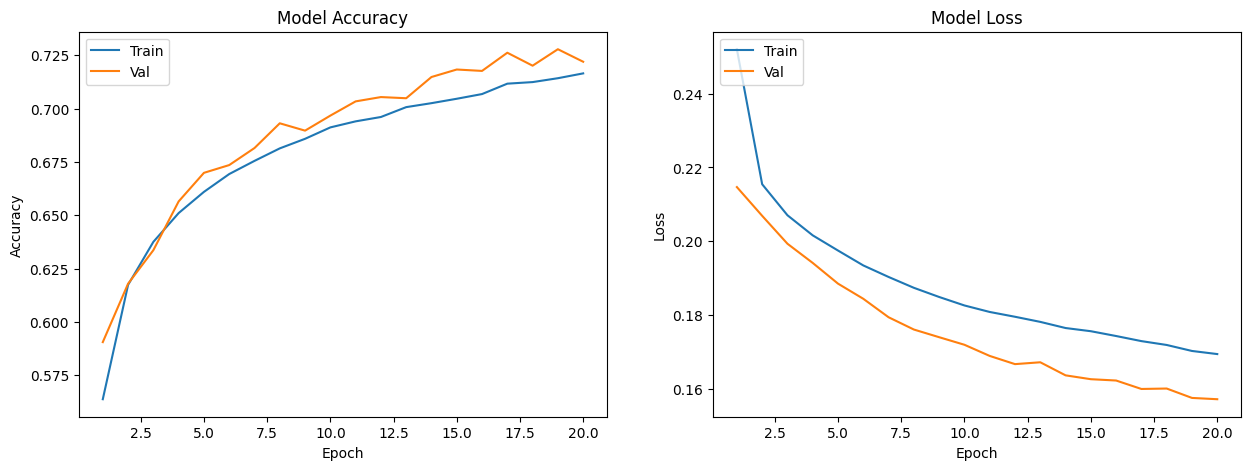

In [63]:
plot_learning_curve(history)

In [64]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                 tags
0   train_40458        [agriculture, clear, primary]
1   train_40459                     [clear, primary]
2   train_40460                     [clear, primary]
3   train_40461                       [cloudy, haze]
4   train_40462                     [clear, primary]
5   train_40463                            [primary]
6   train_40464        [agriculture, clear, primary]
7   train_40465                     [clear, primary]
8   train_40466                     [clear, primary]
9   train_40467               [agriculture, primary]
10  train_40468  [agriculture, clear, primary, road]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                                  cloudy
40462  train

## Approach 3 agument= True, dropout = True

config = {
    'batch_size': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= True

Model = MyCNN(use_dropout=True)

In [66]:
model, history = fit(augmentation=True,transfer=False,use_dropout=True, opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

Dropout: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         Dropout2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
        Dropout2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14     

Epoch 1/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.87it/s]


Epoch 1/20, train loss: 0.2523, val loss: 0.2154, train acc: 0.5586, val acc: 0.5765


Epoch 2/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  7.94it/s]


Epoch 2/20, train loss: 0.2184, val loss: 0.2057, train acc: 0.6090, val acc: 0.6208


Epoch 3/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.00it/s]


Epoch 3/20, train loss: 0.2107, val loss: 0.1999, train acc: 0.6296, val acc: 0.6471


Epoch 4/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  7.92it/s]


Epoch 4/20, train loss: 0.2058, val loss: 0.1961, train acc: 0.6430, val acc: 0.6541


Epoch 5/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.35it/s]


Epoch 5/20, train loss: 0.2017, val loss: 0.1915, train acc: 0.6518, val acc: 0.6601


Epoch 6/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.40it/s]


Epoch 6/20, train loss: 0.1980, val loss: 0.1882, train acc: 0.6606, val acc: 0.6750


Epoch 7/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.15it/s]


Epoch 7/20, train loss: 0.1963, val loss: 0.1880, train acc: 0.6651, val acc: 0.6654


Epoch 8/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.30it/s]


Epoch 8/20, train loss: 0.1932, val loss: 0.1843, train acc: 0.6722, val acc: 0.6789


Epoch 9/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.33it/s]


Epoch 9/20, train loss: 0.1911, val loss: 0.1804, train acc: 0.6776, val acc: 0.6836


Epoch 10/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.24it/s]


Epoch 10/20, train loss: 0.1895, val loss: 0.1791, train acc: 0.6808, val acc: 0.6871


Epoch 11/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.17it/s]


Epoch 11/20, train loss: 0.1881, val loss: 0.1758, train acc: 0.6829, val acc: 0.6980


Epoch 12/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.32it/s]


Epoch 12/20, train loss: 0.1863, val loss: 0.1733, train acc: 0.6858, val acc: 0.7011


Epoch 13/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.90it/s]


Epoch 13/20, train loss: 0.1856, val loss: 0.1719, train acc: 0.6886, val acc: 0.7056


Epoch 14/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.54it/s]


Epoch 14/20, train loss: 0.1844, val loss: 0.1712, train acc: 0.6911, val acc: 0.7000


Epoch 15/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.83it/s]


Epoch 15/20, train loss: 0.1828, val loss: 0.1707, train acc: 0.6936, val acc: 0.7125


Epoch 16/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.36it/s]


Epoch 16/20, train loss: 0.1822, val loss: 0.1685, train acc: 0.6961, val acc: 0.7112


Epoch 17/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.48it/s]


Epoch 17/20, train loss: 0.1806, val loss: 0.1683, train acc: 0.6992, val acc: 0.7038


Epoch 18/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:14<00:00,  4.45it/s]


Epoch 18/20, train loss: 0.1801, val loss: 0.1674, train acc: 0.6988, val acc: 0.7097


Epoch 19/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  4.95it/s]


Epoch 19/20, train loss: 0.1787, val loss: 0.1658, train acc: 0.7033, val acc: 0.7081


Epoch 20/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.36it/s]

Epoch 20/20, train loss: 0.1778, val loss: 0.1646, train acc: 0.7047, val acc: 0.7182


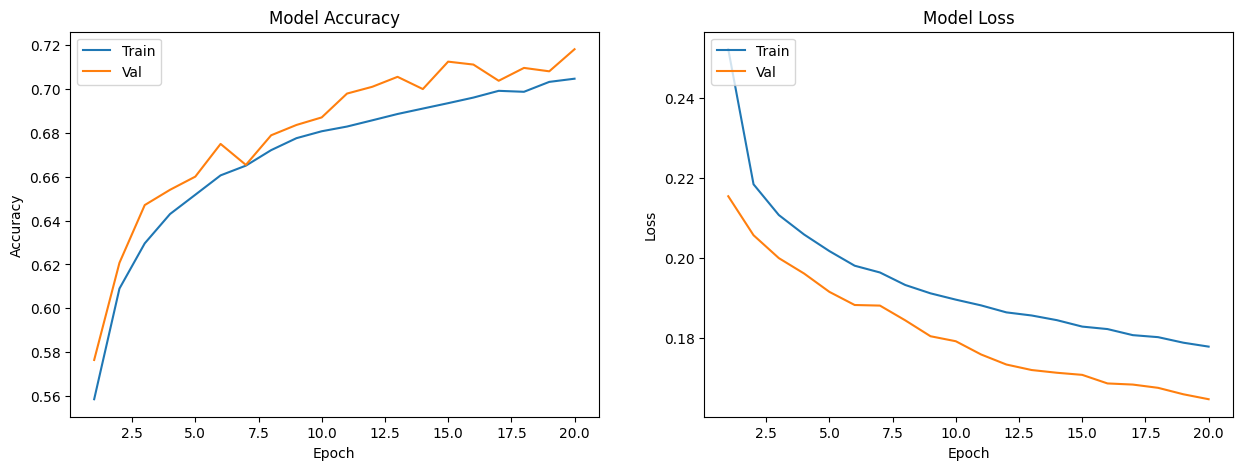

In [68]:
plot_learning_curve(history)

In [69]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                 tags
0   train_40458        [agriculture, clear, primary]
1   train_40459                     [clear, primary]
2   train_40460                     [clear, primary]
3   train_40461                       [cloudy, haze]
4   train_40462                     [clear, primary]
5   train_40463                            [primary]
6   train_40464               [agriculture, primary]
7   train_40465                     [clear, primary]
8   train_40466                     [clear, primary]
9   train_40467  [agriculture, clear, primary, road]
10  train_40468  [agriculture, clear, primary, road]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                                  cloudy
40462  train

## Approach 4 agument= True, dropout = False

config = {
    'batch_size': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= True

Model = MyCNN(use_dropout=False)

In [71]:
model, history = fit(augmentation=True,transfer=False,use_dropout=False, opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

Dropout: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
         Dropout2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
        Dropout2d-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14    

Epoch 1/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.15it/s]


Epoch 1/20, train loss: 0.2157, val loss: 0.1794, train acc: 0.6544, val acc: 0.7073


Epoch 2/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.95it/s]


Epoch 2/20, train loss: 0.1812, val loss: 0.1712, train acc: 0.7056, val acc: 0.7265


Epoch 3/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.07it/s]


Epoch 3/20, train loss: 0.1692, val loss: 0.1573, train acc: 0.7298, val acc: 0.7435


Epoch 4/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.89it/s]


Epoch 4/20, train loss: 0.1636, val loss: 0.1526, train acc: 0.7400, val acc: 0.7399


Epoch 5/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.12it/s]


Epoch 5/20, train loss: 0.1595, val loss: 0.1482, train acc: 0.7475, val acc: 0.7571


Epoch 6/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.29it/s]


Epoch 6/20, train loss: 0.1550, val loss: 0.1574, train acc: 0.7560, val acc: 0.7690


Epoch 7/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.34it/s]


Epoch 7/20, train loss: 0.1542, val loss: 0.1436, train acc: 0.7570, val acc: 0.7716


Epoch 8/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch 8/20, train loss: 0.1508, val loss: 0.1436, train acc: 0.7636, val acc: 0.7568


Epoch 9/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:13<00:00,  4.82it/s]


Epoch 9/20, train loss: 0.1487, val loss: 0.1510, train acc: 0.7673, val acc: 0.7540


Epoch 10/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.36it/s]


Epoch 10/20, train loss: 0.1472, val loss: 0.1496, train acc: 0.7700, val acc: 0.7606


Epoch 11/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.55it/s]


Epoch 11/20, train loss: 0.1461, val loss: 0.1342, train acc: 0.7705, val acc: 0.7839


Epoch 12/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.04it/s]


Epoch 12/20, train loss: 0.1443, val loss: 0.1382, train acc: 0.7754, val acc: 0.7827


Epoch 13/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  5.85it/s]


Epoch 13/20, train loss: 0.1426, val loss: 0.1390, train acc: 0.7771, val acc: 0.7864


Epoch 14/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.83it/s]


Epoch 14/20, train loss: 0.1417, val loss: 0.1382, train acc: 0.7798, val acc: 0.7800


Epoch 15/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.26it/s]


Epoch 15/20, train loss: 0.1413, val loss: 0.1327, train acc: 0.7812, val acc: 0.7961


Epoch 16/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:06<00:00,  9.29it/s]


Epoch 16/20, train loss: 0.1398, val loss: 0.1327, train acc: 0.7829, val acc: 0.7821


Epoch 17/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.84it/s]


Epoch 17/20, train loss: 0.1393, val loss: 0.1356, train acc: 0.7837, val acc: 0.7960


Epoch 18/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.88it/s]


Epoch 18/20, train loss: 0.1385, val loss: 0.1337, train acc: 0.7866, val acc: 0.7943


Epoch 19/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:16<00:00,  3.74it/s]


Epoch 19/20, train loss: 0.1378, val loss: 0.1296, train acc: 0.7861, val acc: 0.8009


Epoch 20/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.14it/s]

Epoch 20/20, train loss: 0.1361, val loss: 0.1324, train acc: 0.7909, val acc: 0.7945


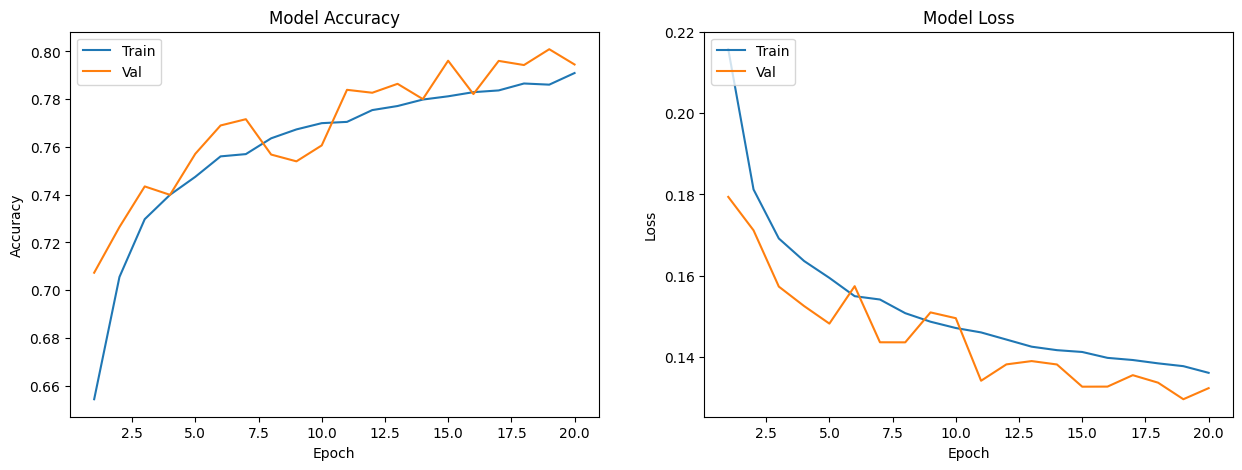

In [74]:
plot_learning_curve(history)

In [75]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                   tags
0   train_40458          [agriculture, clear, primary]
1   train_40459                       [clear, primary]
2   train_40460                       [clear, primary]
3   train_40461                               [cloudy]
4   train_40462                       [clear, primary]
5   train_40463                 [agriculture, primary]
6   train_40464  [agriculture, partly_cloudy, primary]
7   train_40465                       [clear, primary]
8   train_40466                       [clear, primary]
9   train_40467   [agriculture, clear, primary, water]
10  train_40468   [agriculture, clear, primary, water]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                             

## Approach 5 Pretrained VGG Modelby setting transfer=True and agument= False, dropout = False

Uncomment the unfrozen version class VGG16MultiLabel and comment the frozen verson in the cell where model has been defined.

config = {
    'batch_size': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= False

Model = VGG16MultiLabel(use_dropout=False)

In [78]:
model, history = fit(augmentation=False,transfer=True,use_dropout=False,opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

Dropout:  False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14   

Epoch 1/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.86it/s]


Epoch 1/20, train loss: 0.1595, val loss: 0.1015, train acc: 0.7772, val acc: 0.8552


Epoch 2/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.25it/s]


Epoch 2/20, train loss: 0.0984, val loss: 0.0958, train acc: 0.8597, val acc: 0.8661


Epoch 3/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.02it/s]


Epoch 3/20, train loss: 0.0879, val loss: 0.0941, train acc: 0.8744, val acc: 0.8655


Epoch 4/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.19it/s]


Epoch 4/20, train loss: 0.0810, val loss: 0.0968, train acc: 0.8858, val acc: 0.8568


Epoch 5/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.71it/s]


Epoch 5/20, train loss: 0.0728, val loss: 0.0958, train acc: 0.8992, val acc: 0.8578


Epoch 6/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.51it/s]


Epoch 6/20, train loss: 0.0635, val loss: 0.1007, train acc: 0.9127, val acc: 0.8622


Epoch 7/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.14it/s]


Epoch 7/20, train loss: 0.0525, val loss: 0.1079, train acc: 0.9292, val acc: 0.8703


Epoch 8/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.04it/s]


Epoch 8/20, train loss: 0.0414, val loss: 0.1210, train acc: 0.9463, val acc: 0.8675


Epoch 9/20 - Validation: 100%|███████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.97it/s]


Epoch 9/20, train loss: 0.0322, val loss: 0.1410, train acc: 0.9590, val acc: 0.8691


Epoch 10/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.14it/s]


Epoch 10/20, train loss: 0.0253, val loss: 0.1569, train acc: 0.9687, val acc: 0.8649


Epoch 11/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.18it/s]


Epoch 11/20, train loss: 0.0201, val loss: 0.1789, train acc: 0.9758, val acc: 0.8700


Epoch 12/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.20it/s]


Epoch 12/20, train loss: 0.0186, val loss: 0.1851, train acc: 0.9776, val acc: 0.8667


Epoch 13/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.43it/s]


Epoch 13/20, train loss: 0.0150, val loss: 0.2076, train acc: 0.9823, val acc: 0.8681


Epoch 14/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.43it/s]


Epoch 14/20, train loss: 0.0124, val loss: 0.2232, train acc: 0.9855, val acc: 0.8669


Epoch 15/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.17it/s]


Epoch 15/20, train loss: 0.0123, val loss: 0.2289, train acc: 0.9853, val acc: 0.8666


Epoch 16/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.06it/s]


Epoch 16/20, train loss: 0.0099, val loss: 0.2438, train acc: 0.9881, val acc: 0.8758


Epoch 17/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.09it/s]


Epoch 17/20, train loss: 0.0091, val loss: 0.2439, train acc: 0.9891, val acc: 0.8702


Epoch 18/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:26<00:00,  2.36it/s]


Epoch 18/20, train loss: 0.0089, val loss: 0.2564, train acc: 0.9895, val acc: 0.8606


Epoch 19/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:17<00:00,  3.54it/s]


Epoch 19/20, train loss: 0.0074, val loss: 0.2995, train acc: 0.9912, val acc: 0.8750


Epoch 20/20 - Validation: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:18<00:00,  3.36it/s]

Epoch 20/20, train loss: 0.0072, val loss: 0.3115, train acc: 0.9911, val acc: 0.8729


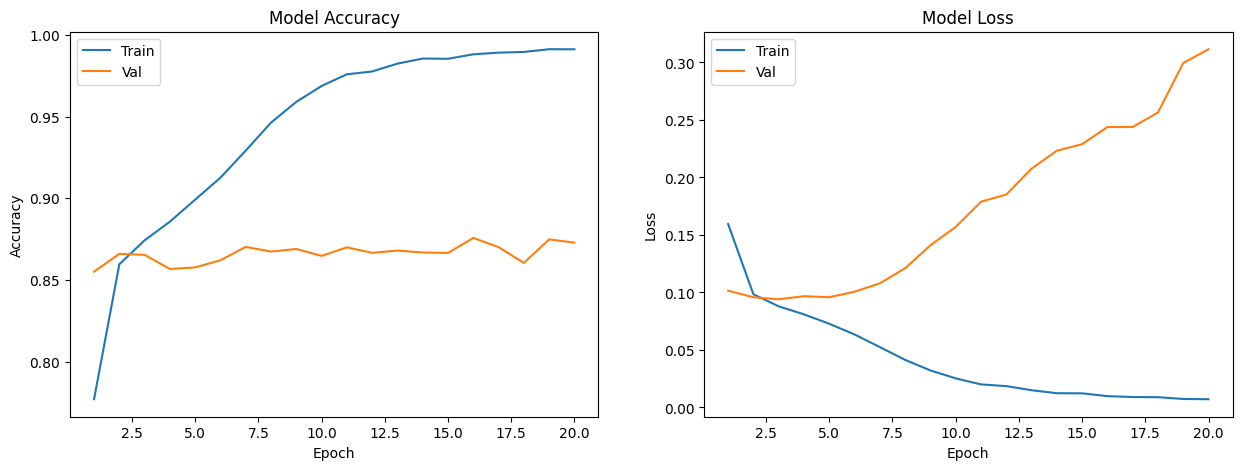

In [84]:
plot_learning_curve(history)

In [85]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                               tags
0   train_40458                [agriculture, clear, primary, road]
1   train_40459                            [clear, primary, water]
2   train_40460                                   [clear, primary]
3   train_40461                                           [cloudy]
4   train_40462                                   [clear, primary]
5   train_40463                       [agriculture, haze, primary]
6   train_40464  [agriculture, haze, partly_cloudy, primary, road]
7   train_40465                                   [clear, primary]
8   train_40466                                   [clear, primary]
9   train_40467                       [agriculture, primary, road]
10  train_40468               [agriculture, clear, primary, water]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459   

## Approach 6 Pretrained VGG Model(frozen layers with reduced number of parameters) by setting transfer=True and agument= False, dropout = False
Uncomment the frozen version of VGG16MultiLabel and comment the Unfrozen one. 
config = {
    'batch_size': 128,
    'dropout': 0.5, 
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= False

Model = VGG16MultiLabel(use_dropout=False)

In [34]:
model, history = fit(augmentation=False,transfer=True,use_dropout=False,opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dropout: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14    

Epoch 1/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.67it/s]


Epoch 1/20, train loss: 0.2172, val loss: 0.1579, train acc: 0.6661, val acc: 0.7521


Epoch 2/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.24it/s]


Epoch 2/20, train loss: 0.1549, val loss: 0.1428, train acc: 0.7585, val acc: 0.7850


Epoch 3/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.24it/s]


Epoch 3/20, train loss: 0.1460, val loss: 0.1369, train acc: 0.7773, val acc: 0.7945


Epoch 4/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.23it/s]


Epoch 4/20, train loss: 0.1417, val loss: 0.1334, train acc: 0.7858, val acc: 0.8027


Epoch 5/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.27it/s]


Epoch 5/20, train loss: 0.1390, val loss: 0.1311, train acc: 0.7911, val acc: 0.8093


Epoch 6/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.25it/s]


Epoch 6/20, train loss: 0.1371, val loss: 0.1297, train acc: 0.7930, val acc: 0.8073


Epoch 7/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.24it/s]


Epoch 7/20, train loss: 0.1354, val loss: 0.1281, train acc: 0.7971, val acc: 0.8093


Epoch 8/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.26it/s]


Epoch 8/20, train loss: 0.1339, val loss: 0.1270, train acc: 0.7980, val acc: 0.8119


Epoch 9/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.27it/s]


Epoch 9/20, train loss: 0.1332, val loss: 0.1258, train acc: 0.8007, val acc: 0.8142


Epoch 10/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.24it/s]


Epoch 10/20, train loss: 0.1320, val loss: 0.1250, train acc: 0.8025, val acc: 0.8168


Epoch 11/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.31it/s]


Epoch 11/20, train loss: 0.1317, val loss: 0.1242, train acc: 0.8035, val acc: 0.8170


Epoch 12/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.23it/s]


Epoch 12/20, train loss: 0.1310, val loss: 0.1236, train acc: 0.8043, val acc: 0.8230


Epoch 13/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.32it/s]


Epoch 13/20, train loss: 0.1304, val loss: 0.1229, train acc: 0.8053, val acc: 0.8198


Epoch 14/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.30it/s]


Epoch 14/20, train loss: 0.1292, val loss: 0.1225, train acc: 0.8083, val acc: 0.8182


Epoch 15/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.30it/s]


Epoch 15/20, train loss: 0.1288, val loss: 0.1221, train acc: 0.8082, val acc: 0.8252


Epoch 16/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.31it/s]


Epoch 16/20, train loss: 0.1287, val loss: 0.1217, train acc: 0.8085, val acc: 0.8248


Epoch 17/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.25it/s]


Epoch 17/20, train loss: 0.1283, val loss: 0.1214, train acc: 0.8097, val acc: 0.8223


Epoch 18/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.30it/s]


Epoch 18/20, train loss: 0.1275, val loss: 0.1206, train acc: 0.8110, val acc: 0.8220


Epoch 19/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.30it/s]


Epoch 19/20, train loss: 0.1273, val loss: 0.1207, train acc: 0.8106, val acc: 0.8170


Epoch 20/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.27it/s]

Epoch 20/20, train loss: 0.1270, val loss: 0.1208, train acc: 0.8128, val acc: 0.8194


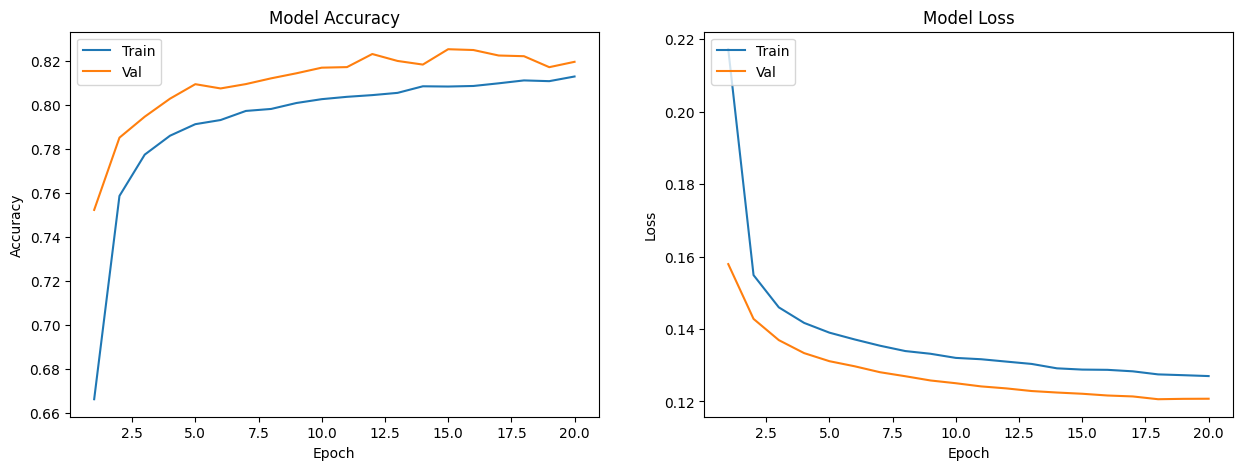

In [37]:
plot_learning_curve(history)

In [38]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                 tags
0   train_40458        [agriculture, clear, primary]
1   train_40459                     [clear, primary]
2   train_40460                     [clear, primary]
3   train_40461                             [cloudy]
4   train_40462                     [clear, primary]
5   train_40463         [agriculture, haze, primary]
6   train_40464   [agriculture, haze, primary, road]
7   train_40465                     [clear, primary]
8   train_40466                     [clear, primary]
9   train_40467  [agriculture, clear, primary, road]
10  train_40468        [agriculture, clear, primary]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                                  cloudy
40462  train

## Approach 7 Pretrained VGG Model(frozen layers with reduced number of parameters) by setting transfer=True and agument= True, dropout = False
Uncomment the frozen version of VGG16MultiLabel and comment the Unfrozen one. 
config = {
    'batch_size': 128,
    'dropout': 0.5, 
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= True

Model = VGG16MultiLabel(use_dropout=False)

In [40]:
model, history = fit(augmentation=True,transfer=True,use_dropout=False,opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dropout: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14    

Epoch 1/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.16it/s]


Epoch 1/20, train loss: 0.2215, val loss: 0.1660, train acc: 0.6599, val acc: 0.7418


Epoch 2/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 2/20, train loss: 0.1634, val loss: 0.1524, train acc: 0.7422, val acc: 0.7690


Epoch 3/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.13it/s]


Epoch 3/20, train loss: 0.1549, val loss: 0.1463, train acc: 0.7617, val acc: 0.7761


Epoch 4/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.07it/s]


Epoch 4/20, train loss: 0.1508, val loss: 0.1431, train acc: 0.7706, val acc: 0.7883


Epoch 5/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 5/20, train loss: 0.1490, val loss: 0.1419, train acc: 0.7740, val acc: 0.7928


Epoch 6/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.09it/s]


Epoch 6/20, train loss: 0.1471, val loss: 0.1392, train acc: 0.7776, val acc: 0.7961


Epoch 7/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 7/20, train loss: 0.1450, val loss: 0.1385, train acc: 0.7805, val acc: 0.7996


Epoch 8/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.15it/s]


Epoch 8/20, train loss: 0.1449, val loss: 0.1379, train acc: 0.7823, val acc: 0.8005


Epoch 9/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.13it/s]


Epoch 9/20, train loss: 0.1437, val loss: 0.1347, train acc: 0.7840, val acc: 0.7966


Epoch 10/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 10/20, train loss: 0.1431, val loss: 0.1358, train acc: 0.7854, val acc: 0.8001


Epoch 11/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.12it/s]


Epoch 11/20, train loss: 0.1421, val loss: 0.1340, train acc: 0.7880, val acc: 0.8020


Epoch 12/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 12/20, train loss: 0.1412, val loss: 0.1343, train acc: 0.7886, val acc: 0.8064


Epoch 13/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.16it/s]


Epoch 13/20, train loss: 0.1406, val loss: 0.1340, train acc: 0.7901, val acc: 0.8039


Epoch 14/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.10it/s]


Epoch 14/20, train loss: 0.1407, val loss: 0.1337, train acc: 0.7900, val acc: 0.8068


Epoch 15/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 15/20, train loss: 0.1404, val loss: 0.1329, train acc: 0.7898, val acc: 0.8015


Epoch 16/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.07it/s]


Epoch 16/20, train loss: 0.1395, val loss: 0.1337, train acc: 0.7918, val acc: 0.7995


Epoch 17/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.13it/s]


Epoch 17/20, train loss: 0.1399, val loss: 0.1322, train acc: 0.7925, val acc: 0.8081


Epoch 18/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.08it/s]


Epoch 18/20, train loss: 0.1385, val loss: 0.1319, train acc: 0.7934, val acc: 0.8088


Epoch 19/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.08it/s]


Epoch 19/20, train loss: 0.1390, val loss: 0.1312, train acc: 0.7927, val acc: 0.8103


Epoch 20/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.12it/s]

Epoch 20/20, train loss: 0.1386, val loss: 0.1328, train acc: 0.7948, val acc: 0.8050


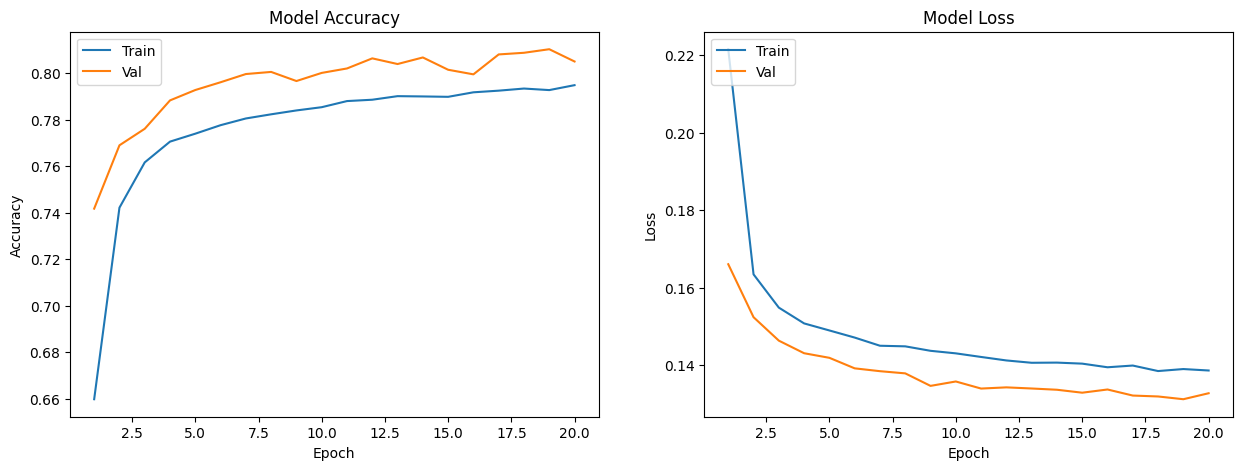

In [41]:
plot_learning_curve(history)

In [43]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                   tags
0   train_40458          [agriculture, clear, primary]
1   train_40459                       [clear, primary]
2   train_40460                       [clear, primary]
3   train_40461                               [cloudy]
4   train_40462                       [clear, primary]
5   train_40463  [agriculture, partly_cloudy, primary]
6   train_40464           [agriculture, primary, road]
7   train_40465                       [clear, primary]
8   train_40466                       [clear, primary]
9   train_40467    [agriculture, clear, primary, road]
10  train_40468    [agriculture, clear, primary, road]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                             

## Approach 8 Pretrained VGG Model(frozen layers with reduced number of parameters) by setting transfer=True and agument= True, dropout = True
Uncomment the frozen version of VGG16MultiLabel and comment the Unfrozen one. 
config = {
    'batch_size': 128,
    'dropout': 0.5, 
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= True

Model = VGG16MultiLabel(use_dropout=True)

In [44]:
model, history = fit(augmentation=True,transfer=True,use_dropout=True,opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dropout: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14     

Epoch 1/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.15it/s]


Epoch 1/20, train loss: 0.2317, val loss: 0.1694, train acc: 0.6465, val acc: 0.7364


Epoch 2/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.14it/s]


Epoch 2/20, train loss: 0.1716, val loss: 0.1537, train acc: 0.7313, val acc: 0.7587


Epoch 3/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.10it/s]


Epoch 3/20, train loss: 0.1632, val loss: 0.1488, train acc: 0.7497, val acc: 0.7729


Epoch 4/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.10it/s]


Epoch 4/20, train loss: 0.1577, val loss: 0.1450, train acc: 0.7593, val acc: 0.7842


Epoch 5/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.12it/s]


Epoch 5/20, train loss: 0.1552, val loss: 0.1432, train acc: 0.7657, val acc: 0.7815


Epoch 6/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.13it/s]


Epoch 6/20, train loss: 0.1532, val loss: 0.1410, train acc: 0.7676, val acc: 0.7846


Epoch 7/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.08it/s]


Epoch 7/20, train loss: 0.1514, val loss: 0.1400, train acc: 0.7713, val acc: 0.7875


Epoch 8/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.09it/s]


Epoch 8/20, train loss: 0.1498, val loss: 0.1387, train acc: 0.7733, val acc: 0.7911


Epoch 9/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.38it/s]


Epoch 9/20, train loss: 0.1493, val loss: 0.1373, train acc: 0.7747, val acc: 0.7937


Epoch 10/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.25it/s]


Epoch 10/20, train loss: 0.1482, val loss: 0.1364, train acc: 0.7768, val acc: 0.7974


Epoch 11/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.14it/s]


Epoch 11/20, train loss: 0.1479, val loss: 0.1361, train acc: 0.7776, val acc: 0.7949


Epoch 12/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.46it/s]


Epoch 12/20, train loss: 0.1467, val loss: 0.1358, train acc: 0.7790, val acc: 0.7929


Epoch 13/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.43it/s]


Epoch 13/20, train loss: 0.1454, val loss: 0.1354, train acc: 0.7822, val acc: 0.7973


Epoch 14/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.48it/s]


Epoch 14/20, train loss: 0.1454, val loss: 0.1349, train acc: 0.7820, val acc: 0.8038


Epoch 15/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.43it/s]


Epoch 15/20, train loss: 0.1449, val loss: 0.1333, train acc: 0.7831, val acc: 0.8028


Epoch 16/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.52it/s]


Epoch 16/20, train loss: 0.1445, val loss: 0.1336, train acc: 0.7825, val acc: 0.7939


Epoch 17/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:09<00:00,  6.47it/s]


Epoch 17/20, train loss: 0.1439, val loss: 0.1338, train acc: 0.7840, val acc: 0.8010


Epoch 18/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.79it/s]


Epoch 18/20, train loss: 0.1431, val loss: 0.1326, train acc: 0.7861, val acc: 0.7999


Epoch 19/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.83it/s]


Epoch 19/20, train loss: 0.1429, val loss: 0.1326, train acc: 0.7861, val acc: 0.8007


Epoch 20/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.80it/s]


Epoch 20/20, train loss: 0.1424, val loss: 0.1324, train acc: 0.7862, val acc: 0.8044


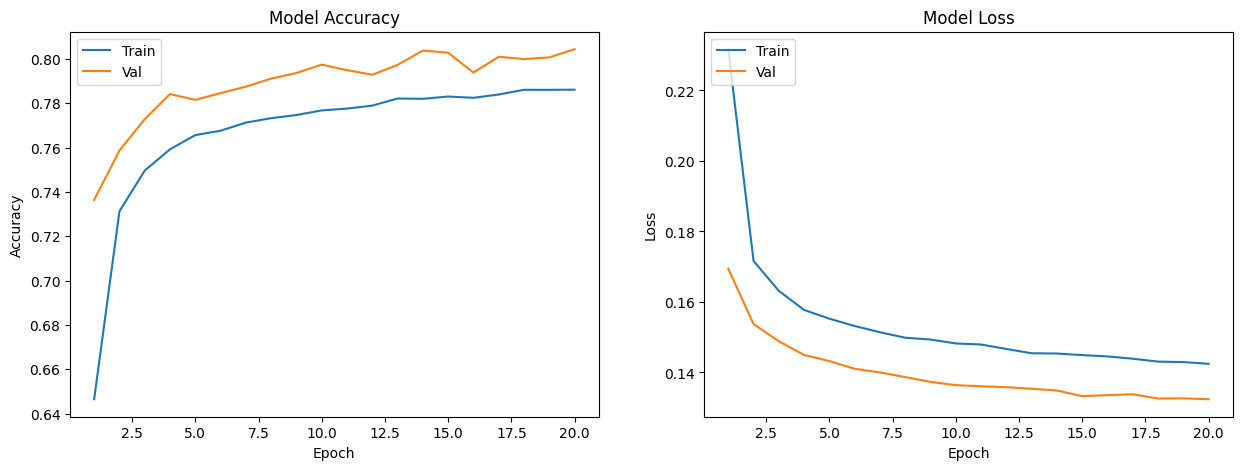

In [45]:
plot_learning_curve(history)

In [46]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                 tags
0   train_40458        [agriculture, clear, primary]
1   train_40459                     [clear, primary]
2   train_40460                     [clear, primary]
3   train_40461                             [cloudy]
4   train_40462                     [clear, primary]
5   train_40463         [agriculture, primary, road]
6   train_40464         [agriculture, primary, road]
7   train_40465                     [clear, primary]
8   train_40466                     [clear, primary]
9   train_40467  [agriculture, clear, primary, road]
10  train_40468  [agriculture, clear, primary, road]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                                  cloudy
40462  train

## Approach 9 Pretrained VGG Model(frozen layers with reduced number of parameters) by setting transfer=True and agument= False, dropout = True
Uncomment the frozen version of VGG16MultiLabel and comment the Unfrozen one. 
config = {
    'batch_size': 128,
    'dropout': 0.5, 
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

Agumentation= False

Model = VGG16MultiLabel(use_dropout=True)

model, history = fit(augmentation=False,transfer=True,use_dropout=True,opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

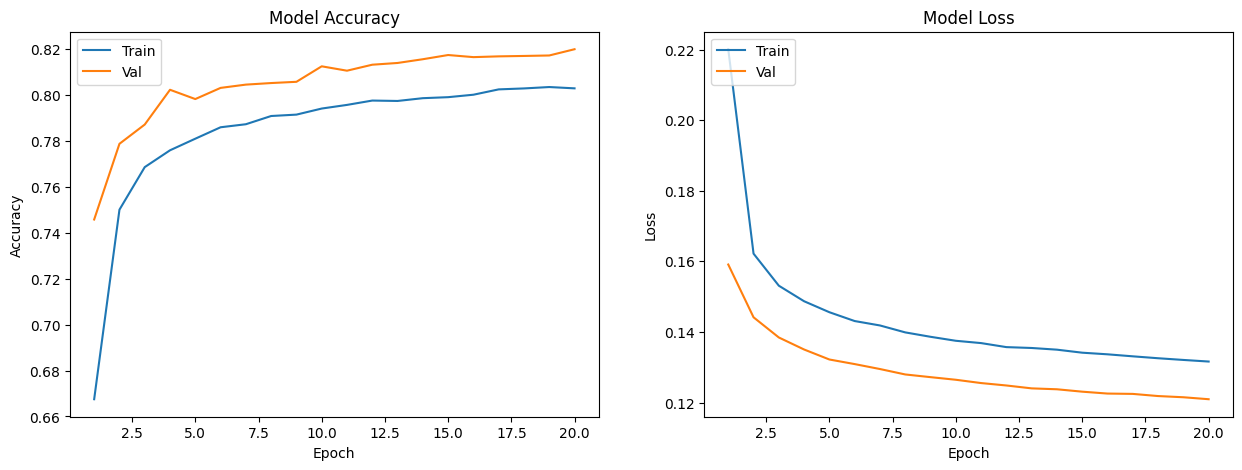

In [48]:
plot_learning_curve(history)

In [49]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                 tags
0   train_40458        [agriculture, clear, primary]
1   train_40459                     [clear, primary]
2   train_40460                     [clear, primary]
3   train_40461                             [cloudy]
4   train_40462                     [clear, primary]
5   train_40463               [agriculture, primary]
6   train_40464         [agriculture, primary, road]
7   train_40465                     [clear, primary]
8   train_40466                     [clear, primary]
9   train_40467  [agriculture, clear, primary, road]
10  train_40468        [agriculture, clear, primary]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                           clear primary
40461  train_40461                                  cloudy
40462  train

## Approach 10 Pretrained VGG Model(Unfrozen version with all trainable parameters) by setting transfer=True and agument= False, dropout = True, update epochs to 10 in config file
Uncomment the Unfrozen version of VGG16MultiLabel and comment the frozen one. 
config = {
    'batch_size': 128,
    'dropout': 0.5, 
    'lr': 0.01,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':10 
}

Agumentation= False

Model = VGG16MultiLabel(use_dropout=True)

In [60]:
config = {
    'batch_size': 128,
    'dropout': 0.5, 
    'lr': 0.001,
    'optimizer':'SGD',
    # 'optimizer':'Adam',    
    'epochs':20 
}

In [62]:
model, history = fit(augmentation=False,transfer=True,use_dropout=True,opt=config['optimizer'], epochs=config['epochs'], lr=config['lr'])

/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xsingh1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dropout:  True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14    

Epoch 1/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.28it/s]


Epoch 1/20, train loss: 0.2816, val loss: 0.1579, train acc: 0.6191, val acc: 0.7370


Epoch 2/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.28it/s]


Epoch 2/20, train loss: 0.1507, val loss: 0.1278, train acc: 0.7616, val acc: 0.8253


Epoch 3/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.28it/s]


Epoch 3/20, train loss: 0.1315, val loss: 0.1167, train acc: 0.8050, val acc: 0.8343


Epoch 4/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.99it/s]


Epoch 4/20, train loss: 0.1215, val loss: 0.1109, train acc: 0.8224, val acc: 0.8456


Epoch 5/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.95it/s]


Epoch 5/20, train loss: 0.1159, val loss: 0.1071, train acc: 0.8313, val acc: 0.8577


Epoch 6/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 10.97it/s]


Epoch 6/20, train loss: 0.1118, val loss: 0.1069, train acc: 0.8373, val acc: 0.8682


Epoch 7/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.21it/s]


Epoch 7/20, train loss: 0.1080, val loss: 0.1033, train acc: 0.8429, val acc: 0.8670


Epoch 8/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.23it/s]


Epoch 8/20, train loss: 0.1055, val loss: 0.1010, train acc: 0.8475, val acc: 0.8639


Epoch 9/20 - Validation: 100%|██████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.54it/s]


Epoch 9/20, train loss: 0.1034, val loss: 0.1011, train acc: 0.8511, val acc: 0.8741


Epoch 10/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.55it/s]


Epoch 10/20, train loss: 0.1018, val loss: 0.0985, train acc: 0.8533, val acc: 0.8671


Epoch 11/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.56it/s]


Epoch 11/20, train loss: 0.1000, val loss: 0.0986, train acc: 0.8568, val acc: 0.8717


Epoch 12/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.52it/s]


Epoch 12/20, train loss: 0.0990, val loss: 0.0983, train acc: 0.8574, val acc: 0.8791


Epoch 13/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.54it/s]


Epoch 13/20, train loss: 0.0973, val loss: 0.0967, train acc: 0.8606, val acc: 0.8773


Epoch 14/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.53it/s]


Epoch 14/20, train loss: 0.0956, val loss: 0.0973, train acc: 0.8635, val acc: 0.8724


Epoch 15/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.54it/s]


Epoch 15/20, train loss: 0.0948, val loss: 0.0958, train acc: 0.8639, val acc: 0.8761


Epoch 16/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.29it/s]


Epoch 16/20, train loss: 0.0938, val loss: 0.0954, train acc: 0.8659, val acc: 0.8767


Epoch 17/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.29it/s]


Epoch 17/20, train loss: 0.0927, val loss: 0.0941, train acc: 0.8675, val acc: 0.8798


Epoch 18/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.29it/s]


Epoch 18/20, train loss: 0.0916, val loss: 0.0941, train acc: 0.8699, val acc: 0.8784


Epoch 19/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.29it/s]


Epoch 19/20, train loss: 0.0905, val loss: 0.0945, train acc: 0.8708, val acc: 0.8802


Epoch 20/20 - Validation: 100%|█████████████████████████████████████████████████████████| 63/63 [00:05<00:00, 11.29it/s]

Epoch 20/20, train loss: 0.0896, val loss: 0.0938, train acc: 0.8734, val acc: 0.8765


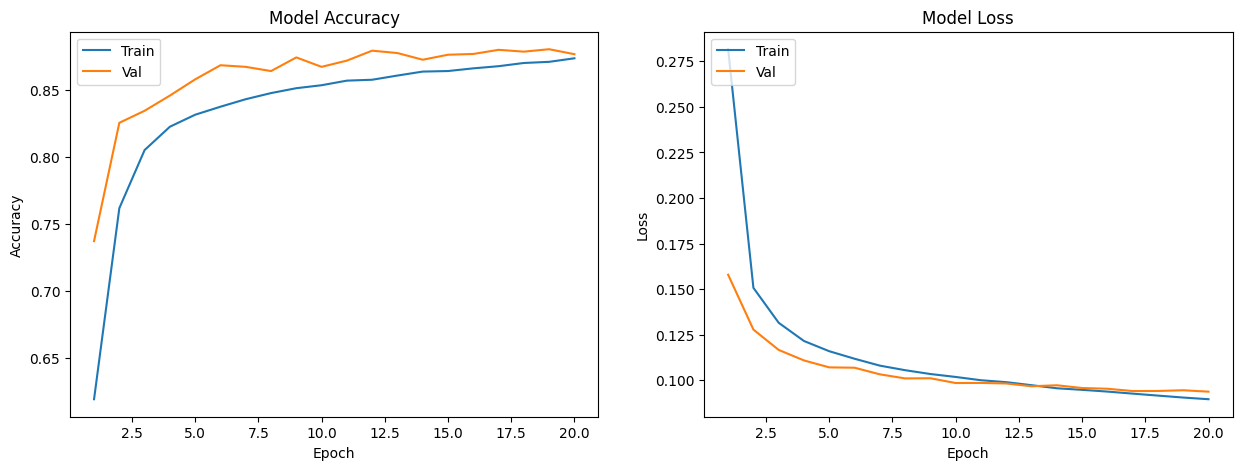

In [63]:
plot_learning_curve(history)

In [66]:
visual_predict(model,40458,40468)

Predicted label Dataframe:
      image_name                                         tags
0   train_40458          [agriculture, clear, primary, road]
1   train_40459                      [clear, primary, water]
2   train_40460                             [clear, primary]
3   train_40461                                     [cloudy]
4   train_40462                             [clear, primary]
5   train_40463                 [agriculture, haze, primary]
6   train_40464  [agriculture, partly_cloudy, primary, road]
7   train_40465                             [clear, primary]
8   train_40466                             [clear, primary]
9   train_40467          [agriculture, clear, primary, road]
10  train_40468         [agriculture, clear, primary, water]


original label Dataframe:
         image_name                                    tags
40458  train_40458          agriculture clear primary road
40459  train_40459                     clear primary water
40460  train_40460                

#### Saving Model

In [67]:
torch.save(model.state_dict(), 'model.pth')

#### Function for prediction and creating file as required by kaggle competition

In [69]:
# Function for kaggle format of results
def kaggle_predict(model, start_index=0, end_index=40668):
    results = []
    for i in range(start_index, end_index+1):
        img_path = "planet/test-jpg/"+ 'test_' + str(i) + '.jpg'
        img_name = 'test_' + str(i)
        labels = predict_labels(img_path, model)
        joined_labels = ' '.join(labels)
        results.append({"image_name": img_name, "tags": joined_labels})
    pred_label = pd.DataFrame(results)
    pred_label.to_csv('predicted_labels.csv', index=False)

In [70]:
kaggle_predict(model)

## Analysis of Results

#### Summary:

All models (except last one in table) were trained for 20 epochs with optimizer as SGD, batch size = 128 and learning rate as 0.01. The parameter of learning rate, batch size and optimizer were finalised after multiple trials. These trials has not been included in notebook. Since, it is a multilabel classification problem, weighted Fbeta(beta=2) has been used as accuracy measure and bninary cross entropy is used as loss criterion. The last model was trained with learning rate = 0.001. The performance of various model based on agumentation and dropout parameters are as follows:-

|Model Name | Augmentation | Dropout | Val  Acuuracy | Comments|
|--------------|----------|-----------|---------------|----------|
| Vanilla CNN | False   | False         |   80.91%      | Simple Model architecture and has a decent performance.|
| Vanilla CNN | False   | True         |   72.20%      | Adding dropout reduced accuracy.|
| Vanilla CNN | True   | True         |   71.47%      | Adding augmentation did not improve model performance.|
| Vanilla CNN | True   | False         |   79.45%      | Removing dropout improved accuracy.|
| VGG16MultiLabel<br>(unfrozen version <br>with all trainiable parameters) | False   | False         |   87.29%      | After 20 epochs, the model has achieved training accuracy of 99.11 and val accuracy of 87.29 but after 4 epochs val loss started increaing and val accuracy started dropping. Model seems to be overfitting|
|VGG16MultiLabel<br>(Frozen version <br>with few trainiable parameters) | False   | False         |   81.94%      | The model seems to perform well without dropout and augmentation.|
|VGG16MultiLabel<br>(Frozen version <br>with few trainiable parameters) | True   | False         |   80.50%      | Adding augmentation reduced accuracy by 1%|
|VGG16MultiLabel<br>(Frozen version <br>with few trainiable parameters) | True   | True         |   80.44%      | The Adding dropout had no significat effect on model performance|
|VGG16MultiLabel<br>(Frozen version <br>with few trainiable parameters) | False   | True         |   81.98%      | Removing augmentation improved performance by 1.5%||
|VGG16MultiLabel<br>(unfrozen version <br>with all trainiable parameters) | False   | True         |   87.65%      | Reducing leaning rate and inclusion of dropout improved accuracy drastically|

#### Conclusion:
1. The vanilla CNN and VGG16MultiLabel(Frozen version with all 2,106,385 trainable parameters) without agumentation ad dropout had a decent performance with validation accuracy of about 81%. There is no significant effect of agumentation on our dataset.
2. The model VGG16MultiLabel (unFrozen version with all 134,330,193 trainable parameters) with epoch=20,lr=0.001,opt='SGD',batch_size=128, agumentation= False and dropout=True had best performance. The model has been saved and submitted. 